# Fraud Detection

## Dependencies

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve


## Dataset

It is a synthetic dataset generated using the simulator called PaySim. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods. ([Kaggle](https://www.kaggle.com/datasets/ealaxi/paysim1?select=PS_20174392719_1491204439457_log.csv))

In [2]:
data = pd.read_csv("Fraud.csv")

In [9]:
data.shape

(6362620, 11)

In [11]:
data.head(9)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.0,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.0,0,0


## Feature Engineering

In [17]:
features = pd.DataFrame(index=data.index)

numerical_col = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

features[numerical_col] = data[numerical_col]

In [18]:
features.head(8)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64,170136.00,160296.36,0.0,0.0
1,1864.28,21249.00,19384.72,0.0,0.0
2,181.00,181.00,0.00,0.0,0.0
3,181.00,181.00,0.00,21182.0,0.0
4,11668.14,41554.00,29885.86,0.0,0.0
5,7817.71,53860.00,46042.29,0.0,0.0
6,7107.77,183195.00,176087.23,0.0,0.0
7,7861.64,176087.23,168225.59,0.0,0.0


Since the ```amount``` field of the dataset deviate from the difference between the original and the new balances of one or both the transaction parties we need to create columns for describing the change in balance of both the parties. 

In [20]:
features["changebalanceOrig"] = features["newbalanceOrig"]-features["oldbalanceOrg"]

features["changebalanceDest"] = features["newbalanceDest"]-features["oldbalanceDest"]

In [21]:
features.head(17)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changebalanceOrig,changebalanceDest
0,9839.64,170136.00,160296.36,0.0,0.00,-9839.64,0.00
1,1864.28,21249.00,19384.72,0.0,0.00,-1864.28,0.00
2,181.00,181.00,0.00,0.0,0.00,-181.00,0.00
3,181.00,181.00,0.00,21182.0,0.00,-181.00,-21182.00
4,11668.14,41554.00,29885.86,0.0,0.00,-11668.14,0.00
5,7817.71,53860.00,46042.29,0.0,0.00,-7817.71,0.00
6,7107.77,183195.00,176087.23,0.0,0.00,-7107.77,0.00
7,7861.64,176087.23,168225.59,0.0,0.00,-7861.64,0.00
8,4024.36,2671.00,0.00,0.0,0.00,-2671.00,0.00
9,5337.77,41720.00,36382.23,41898.0,40348.79,-5337.77,-1549.21


Since the ```step``` field gives us the relative timestamps of all transactions in an hourly resolution, we can derive the (hourly) time of the day when the transaction occurred. To do this we simply transform the ‘step’ field by applying the modulo of 24.

In [24]:
features["hours"] = data["step"]%24

In [25]:
features.head(18)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changebalanceOrig,changebalanceDest,hours
0,9839.64,170136.00,160296.36,0.0,0.00,-9839.64,0.00,1
1,1864.28,21249.00,19384.72,0.0,0.00,-1864.28,0.00,1
2,181.00,181.00,0.00,0.0,0.00,-181.00,0.00,1
3,181.00,181.00,0.00,21182.0,0.00,-181.00,-21182.00,1
4,11668.14,41554.00,29885.86,0.0,0.00,-11668.14,0.00,1
5,7817.71,53860.00,46042.29,0.0,0.00,-7817.71,0.00,1
6,7107.77,183195.00,176087.23,0.0,0.00,-7107.77,0.00,1
7,7861.64,176087.23,168225.59,0.0,0.00,-7861.64,0.00,1
8,4024.36,2671.00,0.00,0.0,0.00,-2671.00,0.00,1
9,5337.77,41720.00,36382.23,41898.0,40348.79,-5337.77,-1549.21,1


One-hot encoding all the categorical data.

In [27]:
one_hot = pd.get_dummies(data["type"])

features = pd.concat([features, one_hot], axis=1)

In [91]:
features.head(23)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changebalanceOrig,changebalanceDest,hours,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.00,160296.36,0.0,0.00,-9839.64,0.00,1,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.0,0.00,-1864.28,0.00,1,0,0,0,1,0
2,181.00,181.00,0.00,0.0,0.00,-181.00,0.00,1,0,0,0,0,1
3,181.00,181.00,0.00,21182.0,0.00,-181.00,-21182.00,1,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.0,0.00,-11668.14,0.00,1,0,0,0,1,0
5,7817.71,53860.00,46042.29,0.0,0.00,-7817.71,0.00,1,0,0,0,1,0
6,7107.77,183195.00,176087.23,0.0,0.00,-7107.77,0.00,1,0,0,0,1,0
7,7861.64,176087.23,168225.59,0.0,0.00,-7861.64,0.00,1,0,0,0,1,0
8,4024.36,2671.00,0.00,0.0,0.00,-2671.00,0.00,1,0,0,0,1,0
9,5337.77,41720.00,36382.23,41898.0,40348.79,-5337.77,-1549.21,1,0,0,1,0,0


## Model

Used an __Isolation Forest Model__ for anomaly detection. (Will train further models for comparison as well)

In [30]:
forest = IsolationForest(random_state=11)

forest.fit(features)

IsolationForest(random_state=11)

In [32]:
scores = forest.score_samples(features)

In [34]:
scores

array([-0.47266945, -0.46045859, -0.49067104, ..., -0.71523828,
       -0.57929168, -0.6298106 ])

In [35]:
scores.shape

(6362620,)

## Pred

In [70]:
pred = forest.predict(features)

In [72]:
pred

array([ 1,  1,  1, ..., -1, -1, -1])

In [73]:
pred_func = lambda x: 0 if x==1 else 1

vect_func = np.vectorize(pred_func)

In [74]:
pred = vect_func(pred)

In [75]:
pred

array([0, 0, 0, ..., 1, 1, 1])

## Model Metrics

In [51]:
y = data["isFraud"]


In [65]:
y.unique()

array([0, 1], dtype=int64)

### Accuracy Score

In [77]:
acc_score = accuracy_score(y, pred)

In [78]:
acc_score

0.907508856414496

90% accurate as is (without any pre-processing of data)

### Confusion Matrix

In [79]:
mat = confusion_matrix(y, pred)

mat

array([[5768936,  585471],
       [   3015,    5198]], dtype=int64)

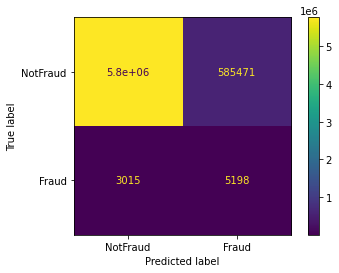

In [93]:
mat_plot = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["NotFraud", "Fraud"])

mat_plot.plot()
plt.show()

True Positive = 5198 <br>
True Negative = 5.8 e+6 <br>

Model is biased towards non-fraudulent data.

### f1 Score

In [86]:
f1 = f1_score(y, pred)

f1

0.017359012292905783

### ROC-AUC

In [88]:
fpr, tpr, threshold = roc_curve(y, scores)

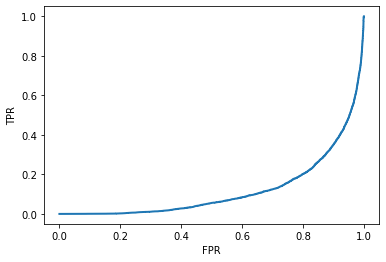

In [90]:
plt.plot(fpr, tpr, lw=2)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()